In [1]:
import tensorflow as tf
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2, os
import numpy as np

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants
from matplotlib import pyplot as plt

In [2]:
img_w = 800 # resized weidth
img_h = 256 # resized height
batch_size = 12
k_size = 3 # kernel size 3x3

In [3]:
def viz_single_fault(img, mask, pred, image_class):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
    
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    
    ax[0].imshow(img)
    ax[0].imshow(mask, alpha=0.3, cmap=cmaps[image_class-1])
    ax[0].set_title('Mask - Defect Class %s' % image_class)
    
    ax[1].imshow(img)
    ax[1].imshow(pred, alpha=0.3, cmap=cmaps[image_class-1])
    ax[1].set_title('Predicted Mask - Defect Class %s' % image_class)
    
    plt.show()
    
def calculate_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    if np.sum(union) == 0:
        iou_score = 0
    else:
        iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [4]:
def mask_to_rle(mask):
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_to_mask(rle_string,height,width):
    rows, cols = height, width
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rleNumbers = [int(numstring) for numstring in rle_string.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols,dtype=np.uint8)
        for index,length in rlePairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

In [5]:
def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x

def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c

In [6]:
def ResUNet(img_h, img_w):
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_h, img_w, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(4, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [7]:
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

In [8]:
def get_batch_data(batch_df, inp_dir, img_h, img_w):
    b_size = len(batch_df)
    X = np.empty((b_size, img_h, img_w, 1))
    Y = np.empty((b_size, img_h, img_w, 4))
    for i in range(b_size):
        filename = batch_df.iloc[i]['ImageId']
        x = cv2.imread(inp_dir + 'train_images/' + filename, 0)
        x = cv2.resize(x, (img_w, img_h))
        x = np.array(x, dtype=np.float64)
        x -= x.mean()
        x /= x.std()
        
        mask = np.empty((img_h, img_w, 4))
        rle = batch_df.iloc[i]['EncodedPixels']
        for idm, image_class in enumerate([1,2,3,4]):
            if batch_df.iloc[i]['ClassId'] == image_class:
                class_mask = rle_to_mask(rle, width=img_w, height=img_h)
            else:
                class_mask = np.zeros((img_w, img_h))

            class_mask_resized = cv2.resize(class_mask, (img_w,img_h))
            mask[...,idm] = class_mask_resized
        y = mask
        y = (y > 0).astype(np.float32)
        
        
        X[i,] = x.reshape(img_h, img_w, 1)
        Y[i,] = y
    return X, Y


In [9]:
model = ResUNet(img_h=img_h, img_w=img_w)
# adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
# model.compile(optimizer=adam, loss=focal_tversky_loss, metrics=[tversky])

W0506 10:07:12.888411 140369609115456 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.load_weights('../../weights_110.h5')

In [11]:
data_dir = '/opt/dkube/input/severstal-steel-defect-detection/'
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))

W0506 10:07:21.872963 140369609115456 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0506 10:07:21.879067 140369609115456 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


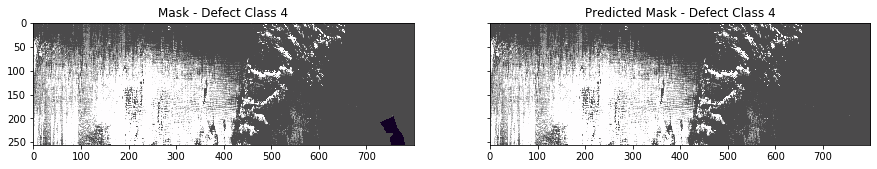

W0506 10:07:22.377706 140369609115456 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0506 10:07:22.384722 140369609115456 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


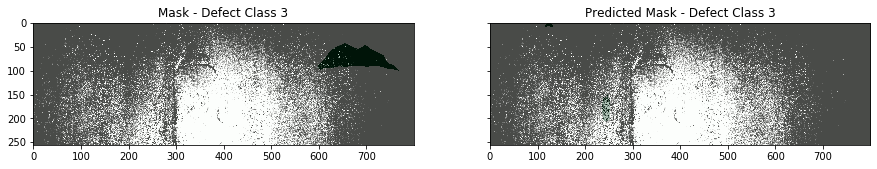

W0506 10:07:22.922962 140369609115456 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0506 10:07:22.930456 140369609115456 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


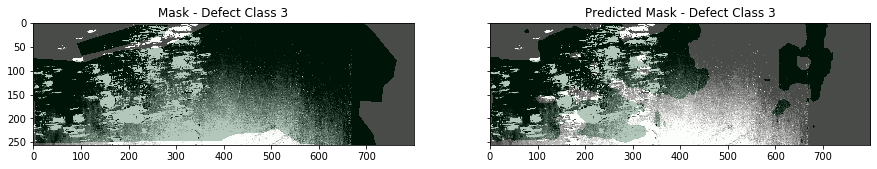

W0506 10:07:23.477241 140369609115456 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0506 10:07:23.483843 140369609115456 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


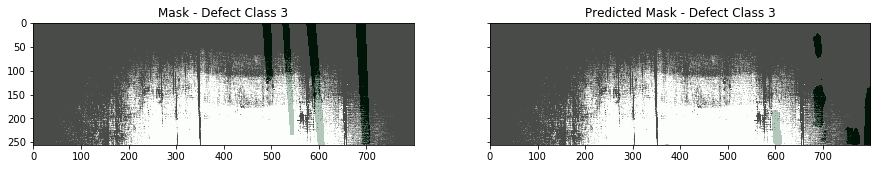

In [12]:
count = 0
class_viz_count = [0,0,0,0]
class_iou_score = [0, 0, 0, 0]
class_mask_sum = [0, 0, 0, 0]
class_pred_sum = [0, 0, 0, 0]

x, y = get_batch_data(train_df[10:15], data_dir, img_h, img_w)
predictions = model.predict(x)

# loop through x to get all the images in the batch
for idx, val in enumerate(x):
    if y[idx].sum() > 0: 
        img = x[idx]
        img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
        masks_temp = [y[idx][...,i] for i in range(0,4)]
        preds_temp = [predictions[idx][...,i] for i in range(0,4)]
        preds_temp = [p > .5 for p in preds_temp]

        for i, (mask, pred) in enumerate(zip(masks_temp, preds_temp)):
            image_class = i + 1
            class_iou_score[i] += calculate_iou(mask, pred)
            class_mask_sum[i] += mask.sum()
            class_pred_sum[i] += pred.sum()
            if mask.sum() > 0 and class_viz_count[i] < 5:
                viz_single_fault(img, mask, pred, image_class)
                class_viz_count[i] += 1


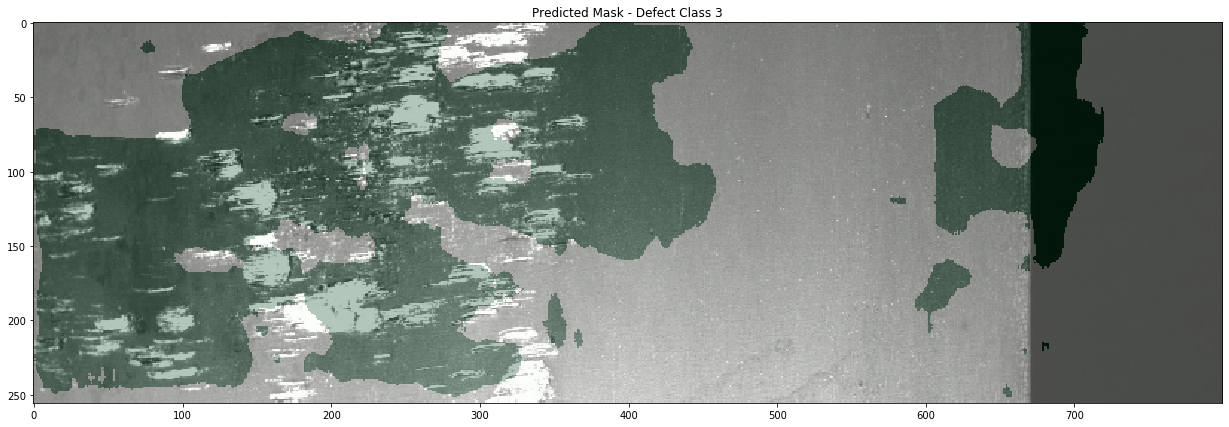

In [13]:
count = 0
class_viz_count = [0,0,0,0]
class_iou_score = [0, 0, 0, 0]
class_mask_sum = [0, 0, 0, 0]
class_pred_sum = [0, 0, 0, 0]

x = cv2.imread(data_dir + 'train_images/005d86c25.jpg', 0)
x = cv2.resize(x, (img_w, img_h))
x = np.array(x, dtype=np.float64)
img = x
x -= x.mean()
x /= x.std()
pred = model.predict(x.reshape(1,img_h, img_w, 1))

# loop through x to get all the images in the batch
for idx, val in enumerate(pred):
    if pred[idx].sum() > 0: 
        img = x[idx]
        img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
        preds_temp = [pred[idx][...,i] for i in range(0,4)]
        preds_temp = [p > .5 for p in preds_temp]

        for i, pred in enumerate(preds_temp):
            image_class = i + 1
            class_pred_sum[i] += pred.sum()
            if pred.sum() > 0 and class_viz_count[i] < 5:
#             if class_viz_count[i] < 5:
                class_viz_count[i] += 1
                fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(25,7))
    
                cmaps = ["Reds", "Blues", "Greens", "Purples"]

                ax.imshow(x, cmap = 'gray')
                ax.imshow(pred, alpha=0.3, cmap=cmaps[image_class-1])
                ax.set_title('Predicted Mask - Defect Class %s' % image_class)

                plt.show()

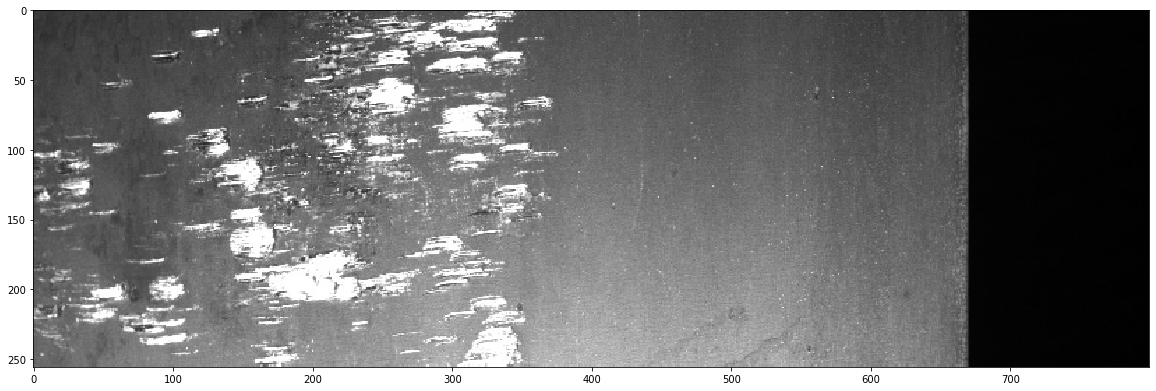

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20,80))
plt.imshow(x.reshape(256,800), cmap = 'gray')